In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw6.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 6: Clustering
### Associated lectures: Lectures 15 and 16

**Due date: Check the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html)**

## Imports <a name="im"></a>

In [2]:
import os
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import (
    average,
    complete,
    dendrogram,
    fcluster,
    single,
    ward,
)
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import cluster, datasets, metrics
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import cluster, datasets, metrics
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

<!-- BEGIN QUESTION -->

<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:6}

**Please be aware that this homework assignment requires installation of several packages in your course environment. It's possible that you'll encounter installation challenges, which might be frustrating. However, remember that solving these issues is not wasting time but it is an essential skill for anyone aspiring to work in data science or machine learning.**

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 4. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb. If the pdf or html also fail to render on Gradescope, please create two files for your homework: hw6a.ipynb with Exercise 1 and hw6b.ipynb with Exercises 2 and 3 and submit these two files in your submission.  
</div>

_Points:_ 6

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 1: Document clustering warm-up
<hr>

In this homework, we will explore a popular application of clustering called [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A, tweets), and clustering is a commonly used technique to organize this data in a meaningful way. 

As a warm up, in this exercise you will cluster sentences from a toy corpus. Later in the homework you will work with a real corpus. 

The code below extracts introductory sentences of Wikipedia articles on a set of queries. To run the code successfully, you will need the `wikipedia` package installed in the course environment. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```


**Your tasks:**

Run the code below which 
- extracts content of Wikipedia articles on a set of queries
- tokenizes the text (i.e., separates sentences) and 
- stores the 2nd sentence in each article as a document representing that article

> Feel free to experiment with Wikipedia queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs to grade your submission.

> For tokenization we are using the `nltk` package. If you do not have this package in the course environment, you will have to install it.

```
conda activate cpsc330
conda install -c anaconda nltk
```

Even if you have the package installed via the course `conda` environment, you might have to download `nltk` pre-trained models, which can be done with the code below.

In [3]:
import nltk

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import wikipedia
from nltk.tokenize import sent_tokenize, word_tokenize

queries = [
    "Artificial Intelligence", "Deep learning", "Unsupervised learning", "Quantum Computing", 
    "Environmental protection", "Climate Change", "Renewable Energy", "Biodiversity",
    "French Cuisine", "Bread food", "Dumpling food"
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    text = sent_tokenize(wikipedia.page(queries[i]).content)[1]
    wiki_dict["text"].append(text)
    wiki_dict["n_words"].append(len(word_tokenize(text)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,Artificial Intelligence,It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.,40
1,Deep learning,"The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and ""training"" them to process data.",25
2,Unsupervised learning,"The training data is processed, building a function that maps new data to expected output values.",18
3,Quantum Computing,"On small scales, physical matter exhibits properties of both particles and waves, and quantum computing leverages this behavior using specialized hardware.",24
4,Environmental protection,"Its objectives are to conserve natural resources and the existing natural environment and, where it is possible, to repair damage and reverse trends.",26
5,Climate Change,Climate change in a broader sense also includes previous long-term changes to Earth's climate.,16
6,Renewable Energy,"The most widely used renewable energy types are solar energy, wind power, and hydropower.",17
7,Biodiversity,It can be measured on various levels.,8
8,French Cuisine,"In the 14th century, Guillaume Tirel, a court chef known as ""Taillevent"", wrote Le Viandier, one of the earliest recipe collections of medieval France.",31
9,Bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20


Our toy corpus has six toy documents (`text` column in the dataframe) extracted from Wikipedia queries. 

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many clusters? 
rubric={points}


**Your tasks:**

1. If you are asked to cluster the documents from this toy corpus manually, how many clusters would you identify and how would you label each cluster?   

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 1

I would cluster them into 3 groups, Machine Learning, Nature Preservation, and food

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 `KMeans` with bag-of-words representation 
rubric={points}

In the lecture, we saw that data representation plays a crucial role in clustering. Changing flattened representation of images to feature vectors extracted from pre-trained models greatly improved the quality of clustering. 

What kind of representation is suitable for text data? We have used bag-of-words representation to numerically encode text data before, where each document is represented with a vector of word frequencies. 

Let's try clustering documents with this simplistic representation.  

**Your tasks:**

1. Create bag-of-words representation using [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) with default arguments for the `text` column in `wiki_df` above.
2. Cluster the encoded documents with [`KMeans` clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Use `random_state=42` (for reproducibility) and set `n_clusters` to the number you identified in the previous exercise.
3. Store the clustering labels in `kmeans_bow_labels` variable below. 

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

In [5]:
vector = CountVectorizer()
bagOfWords = vector.fit_transform(wiki_df['text'])
kmeans = KMeans(n_clusters=3, random_state = 42)

In [6]:
kmeans_bow_labels = kmeans.fit_predict(bagOfWords)

In [7]:
wiki_df["bow_kmeans"] = kmeans_bow_labels
wiki_df

,wiki query,text,n_words,bow_kmeans
0,Artificial Intelligence,It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.,40,2
1,Deep learning,"The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and ""training"" them to process data.",25,1
2,Unsupervised learning,"The training data is processed, building a function that maps new data to expected output values.",18,1
3,Quantum Computing,"On small scales, physical matter exhibits properties of both particles and waves, and quantum computing leverages this behavior using specialized hardware.",24,1
4,Environmental protection,"Its objectives are to conserve natural resources and the existing natural environment and, where it is possible, to repair damage and reverse trends.",26,0
5,Climate Change,Climate change in a broader sense also includes previous long-term changes to Earth's climate.,16,1
6,Renewable Energy,"The most widely used renewable energy types are solar energy, wind power, and hydropower.",17,1
7,Biodiversity,It can be measured on various levels.,8,1
8,French Cuisine,"In the 14th century, Guillaume Tirel, a court chef known as ""Taillevent"", wrote Le Viandier, one of the earliest recipe collections of medieval France.",31,1
9,Bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Sentence embedding representation
rubric={points}

Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer and more expressive representations of text which can be extracted using transfer learning. In this lab, we will use one such representation called sentence embedding representation, which uses deep learning models to generate dense, fixed-length vector representations for sentences. We will extract such representations using sentence transformer package. Sentence embedding takes into account context of words and semantic meaning of sentences and it is likely to work better when we are interested in clustering sentences based on their semantic similarity. 

```
conda activate cpsc330
conda install pytorch::pytorch torchvision torchaudio -c pytorch
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

1. Run the code below to create sentence embedding representation of documents in our toy corpus. 
2. Cluster documents in our toy corpus encoded with this representation (`emb_sents`) and `KMeans` with following arguments: 
    - `random_state=42` (for reproducibility)
    - `n_clusters`=the number of clusters you identified in 1.1
3. Store the clustering labels in `kmeans_emb_labels` variable below. 

In [8]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

# If this cell gives an error, try updating transformers with
# pip install transformers -U

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--sentence-transformers--paraphrase-distilroberta-base-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.102875,0.201959,0.044091,0.281749,0.321483,-0.281129,0.042515,0.083172,0.155722,-0.114267,...,0.310223,-0.141897,-0.153256,-0.058627,0.005015,-0.005808,0.630392,-0.023694,-0.071900,-0.115921
1,0.000322,0.428834,0.152298,-0.161278,0.224354,-0.363829,0.110951,0.042096,0.188454,0.188299,...,-0.092609,-0.117086,0.133018,0.207266,-0.395182,0.085347,0.677385,-0.405457,0.092258,-0.100411
2,0.236465,-0.282463,-0.258300,0.300584,0.234605,0.061746,-0.072744,0.045550,0.271853,0.054201,...,0.531341,-0.095102,0.316027,0.170600,-0.213746,0.110625,0.463024,-0.658667,0.246860,0.171115
3,0.276844,0.657946,0.106466,0.290566,0.803929,0.023764,0.136675,-0.030063,0.115825,0.244903,...,0.069148,-0.183727,0.217584,0.140797,-0.216237,0.128014,0.181907,-0.054305,0.131837,-0.016249
4,0.200328,0.157551,0.093484,0.120533,-0.439307,0.148569,-0.003543,-0.211189,-0.006088,-0.102894,...,0.187549,-0.430333,-0.350163,0.251643,0.115400,-0.053312,0.088485,0.307340,0.355386,0.024684
5,0.189106,0.406864,0.172560,0.273776,0.058933,0.224642,-0.056590,-0.242728,0.056221,0.127506,...,0.099107,-0.350095,0.070398,0.469786,0.003972,-0.130359,-0.105738,-0.091219,0.210350,0.072002
6,-0.066224,0.465512,-0.135840,-0.229255,-0.144746,0.013772,-0.122810,-0.172322,-0.278583,0.002542,...,-0.090149,-0.305184,-0.048772,-0.008466,0.145859,-0.153741,0.012771,0.507823,0.239722,0.015132
7,-0.139882,0.207129,-0.127446,0.214821,-0.099096,0.063319,-0.347634,-0.203128,0.325749,0.624156,...,0.311010,-0.036291,0.004326,0.078006,0.321024,-0.180906,0.553141,-0.010740,0.382759,0.032368
8,-0.112771,-0.259073,0.172584,-0.149188,-0.074585,0.222288,-0.213039,0.512004,0.216943,-0.200929,...,0.083372,0.196123,0.030323,-0.308583,0.061457,-0.008511,0.350080,0.456677,-0.352978,-0.053868
9,-0.022418,0.217159,0.022694,0.003616,0.240856,0.358046,-0.053310,-0.328075,0.190012,0.244470,...,0.265413,-0.415594,0.003036,0.052484,0.345947,0.110091,0.405441,0.197791,-0.058254,0.212376


<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 3

In [10]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(emb_sents)

KMeans(n_clusters=3, random_state=42)

In [11]:
kmeans_emb_labels = kmeans.labels_

In [12]:
wiki_df["emb_kmeans"] = kmeans_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans
0,Artificial Intelligence,It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.,40,2,2
1,Deep learning,"The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and ""training"" them to process data.",25,1,2
2,Unsupervised learning,"The training data is processed, building a function that maps new data to expected output values.",18,1,2
3,Quantum Computing,"On small scales, physical matter exhibits properties of both particles and waves, and quantum computing leverages this behavior using specialized hardware.",24,1,2
4,Environmental protection,"Its objectives are to conserve natural resources and the existing natural environment and, where it is possible, to repair damage and reverse trends.",26,0,0
5,Climate Change,Climate change in a broader sense also includes previous long-term changes to Earth's climate.,16,1,0
6,Renewable Energy,"The most widely used renewable energy types are solar energy, wind power, and hydropower.",17,1,0
7,Biodiversity,It can be measured on various levels.,8,1,1
8,French Cuisine,"In the 14th century, Guillaume Tirel, a court chef known as ""Taillevent"", wrote Le Viandier, one of the earliest recipe collections of medieval France.",31,1,1
9,Bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 DBSCAN with cosine distance  
rubric={points}

Now try [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text data, [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work well. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$


**Your tasks**

1. Cluster documents in our toy corpus encoded with sentence embedding representation (`emb_sents`) and [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html?highlight=dbscan#sklearn.cluster.DBSCAN) with `metric='cosine'`. You will have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values of these hyperparameters are unlikely to work well on this toy dataset.
2. Store the clustering labels in the `dbscan_emb_labels` variable below. 

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

In [13]:
dbscan = DBSCAN(eps = 0.67, min_samples = 1, metric='cosine')
dbscan.fit(emb_sents)
print(dbscan.labels_)

[0 0 0 0 0 0 0 1 2 1 1]


##### 

In [14]:
dbscan_emb_labels = dbscan.labels_

In [15]:
wiki_df["emb_dbscan"] = dbscan_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan
0,Artificial Intelligence,It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.,40,2,2,0
1,Deep learning,"The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and ""training"" them to process data.",25,1,2,0
2,Unsupervised learning,"The training data is processed, building a function that maps new data to expected output values.",18,1,2,0
3,Quantum Computing,"On small scales, physical matter exhibits properties of both particles and waves, and quantum computing leverages this behavior using specialized hardware.",24,1,2,0
4,Environmental protection,"Its objectives are to conserve natural resources and the existing natural environment and, where it is possible, to repair damage and reverse trends.",26,0,0,0
5,Climate Change,Climate change in a broader sense also includes previous long-term changes to Earth's climate.,16,1,0,0
6,Renewable Energy,"The most widely used renewable energy types are solar energy, wind power, and hydropower.",17,1,0,0
7,Biodiversity,It can be measured on various levels.,8,1,1,1
8,French Cuisine,"In the 14th century, Guillaume Tirel, a court chef known as ""Taillevent"", wrote Le Viandier, one of the earliest recipe collections of medieval France.",31,1,1,2
9,Bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,1,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Hierarchical clustering with sentence embedding representation
rubric={points}

**Your tasks:**

Try hierarchical clustering on `emb_sents`. In particular
1. Create and show a dendrogram with `complete` linkage and `metric='cosine'` on this toy dataset.
2. Create flat clusters using `fcluster` with appropriate hyperparameters and store cluster labels to `hier_emb_labels` variable below.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 3

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [52.5, 52.5, 83.75, 83.75],
  [13.75, 13.75, 68.125, 68.125]],
 'dcoord': [[0.0, 0.608417849562485, 0.608417849562485, 0.0],
  [0.0, 0.7237899350872024, 0.7237899350872024, 0.608417849562485],
  [0.0, 0.8933453589684188, 0.8933453589684188, 0.7237899350872024],
  [0.0, 0.6121610664917438, 0.6121610664917438, 0.0],
  [0.0, 0.7385820695026367, 0.7385820695026367, 0.6121610664917438],
  [0.0, 0.4836081332682235, 0.4836081332682235, 0.0],
  [0.0, 0.6763329723403044, 0.6763329723403044, 0.4836081332682235],
  [0.0, 0.7700995517308324, 0.7700995517308324, 0.6763329723403044],
  [0.7385820695026367,
   1.0021016649513308,
   1.0021016649513308,
   0.7700995517308324],
  [0.8933453589684188,
   1.0273084343356687,
   1.0273084343356687,
   1.0021016649513308]]

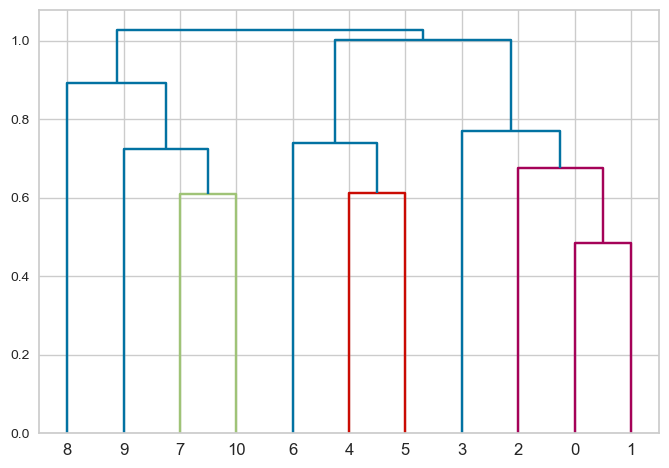

In [16]:
linkage_array = linkage(emb_sent_df, method = "complete", metric = "cosine") 
dendrogram(linkage_array)

In [17]:
hier_emb_labels = fcluster(linkage_array, 3, criterion = "maxclust") 

In [18]:
# hier_emb_labels = fcluster(Z, 3, criterion="maxclust") # alternative solution

In [19]:
wiki_df["emb_hierarchical"] = hier_emb_labels
wiki_df

,wiki query,text,n_words,bow_kmeans,emb_kmeans,emb_dbscan,emb_hierarchical
0,Artificial Intelligence,It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.,40,2,2,0,3
1,Deep learning,"The field takes inspiration from biological neuroscience and is centered around stacking artificial neurons into layers and ""training"" them to process data.",25,1,2,0,3
2,Unsupervised learning,"The training data is processed, building a function that maps new data to expected output values.",18,1,2,0,3
3,Quantum Computing,"On small scales, physical matter exhibits properties of both particles and waves, and quantum computing leverages this behavior using specialized hardware.",24,1,2,0,3
4,Environmental protection,"Its objectives are to conserve natural resources and the existing natural environment and, where it is possible, to repair damage and reverse trends.",26,0,0,0,2
5,Climate Change,Climate change in a broader sense also includes previous long-term changes to Earth's climate.,16,1,0,0,2
6,Renewable Energy,"The most widely used renewable energy types are solar energy, wind power, and hydropower.",17,1,0,0,2
7,Biodiversity,It can be measured on various levels.,8,1,1,1,1
8,French Cuisine,"In the 14th century, Guillaume Tirel, a court chef known as ""Taillevent"", wrote Le Viandier, one of the earliest recipe collections of medieval France.",31,1,1,2,1
9,Bread food,"Throughout recorded history and around the world, it has been an important part of many cultures' diet.",20,1,1,1,1


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.6 Discussion
rubric={points}

**Your tasks:**

1. Reflect on and discuss the clustering results of the methods you explored in the previous exercises, focusing on the following points:    
    - effect of input representation on clustering results
    - whether the clustering results match with your intuitions and the challenges associated with getting the desired clustering results with each method

<div class="alert alert-warning">

Solution_1.6
    
</div>

_Points:_ 4

all the food items are clustered together except for dbscan, all the machine learning items are clustered together except in the bag of words kmeans. the nature reservation items are never all grouped together properly bleeding into the machine learning and food terms often. We had a hard time finding a good hyperparameter for dbscan but decided on a eps of 0.67 and a min_samples of 1 since it gave 3 clusters. sentence embedding performed better than bag of words which put most terms into one big cluster.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

### 1.7 Visualizing clusters
rubric={points:4}


One approach to working with unlabeled data is visualization. That said, our data is high-dimensional, making it challenging to visualize. Take sentence embedding representation as an example: each instance is depicted in 768 dimensions. To visualize such high-dimensional data, we can employ dimensionality reduction techniques to extract the most significant 2 or 3 components, and then visualize this low-dimensional data.

Given data as a `numpy` array and corresponding cluster assignments, the `plot_umap_clusters` function below transforms the data by applying dimensionality reduction technique called [UMAP](https://umap-learn.readthedocs.io/en/latest/) to it and plots the transformed data with different colours for different clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the UMAP part.* 

You'll have to install the `umap-learn` package in the course conda environment either with `conda` or `pip`, as described in the [documentation](https://umap-learn.readthedocs.io/en/latest/index.html). 

```
> conda activate cpsc330
> conda install -c conda-forge umap-learn
```
or

```
> conda activate cpsc330
> pip install umap-learn 
```

If you get an error with the import below try

```
pip install --upgrade numba umap-learn
```

**Your tasks:**

1. Visualize the clusters created by the methods above using `plot_umap_clusters` function below. In other words, visualize clusters identified by each of the methods below. 
    - K-Means with bag-of-words representation 
    - K-Means with sentence embedding representation
    - DBSCAN with sentence embedding representation 
    - Flat cluster of hierarchical clustering with sentence embedding representation     

In [20]:
import umap

In [21]:
def plot_umap_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=50,
    n_neighbors=15,
    title="UMAP visualization",
    ignore_noise=False,
):
    """
    Carry out dimensionality reduction using UMAP and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    n_neighbors : int
        n_neighbors hyperparameter of UMAP. See the documentation.
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, random_state=42)
    Z = reducer.fit_transform(data)  # reduce dimensionality
    umap_df = pd.DataFrame(data=Z, columns=["dim1", "dim2"])
    umap_df["cluster"] = cluster_labels

    if ignore_noise:
        umap_df = umap_df[umap_df["cluster"] != -1]

    labels = np.unique(umap_df["cluster"])

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(title)

    scatter = ax.scatter(
        umap_df["dim1"],
        umap_df["dim2"],
        c=umap_df["cluster"],
        cmap="tab20b",
        s=size,
        #edgecolors="k",
        #linewidths=0.1,
    )

    legend = ax.legend(*scatter.legend_elements(), loc="best", title="Clusters")
    ax.add_artist(legend)

    if show_labels:
        x = umap_df["dim1"].tolist()
        y = umap_df["dim2"].tolist()
        for i, txt in enumerate(raw_sents):
            ax.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
    plt.show()

<div class="alert alert-warning">

Solution_1.7
    
</div>

_Points:_ 4

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


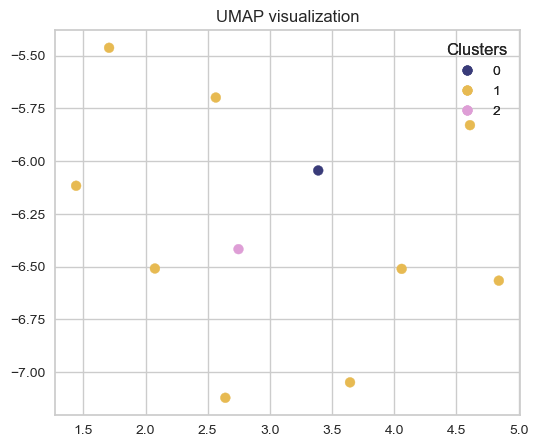

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


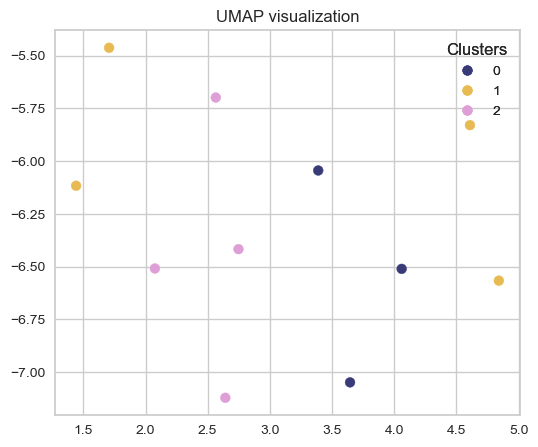

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


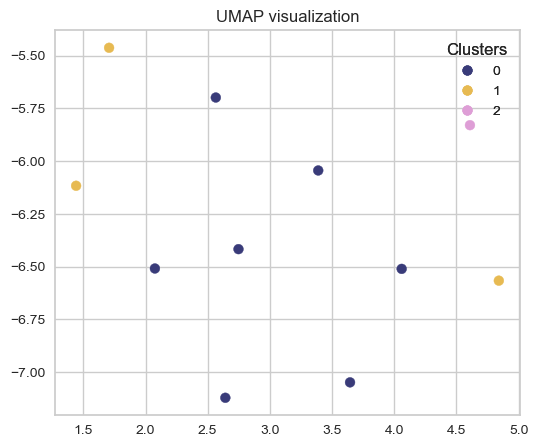

C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\User\miniconda3\envs\cpsc330\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


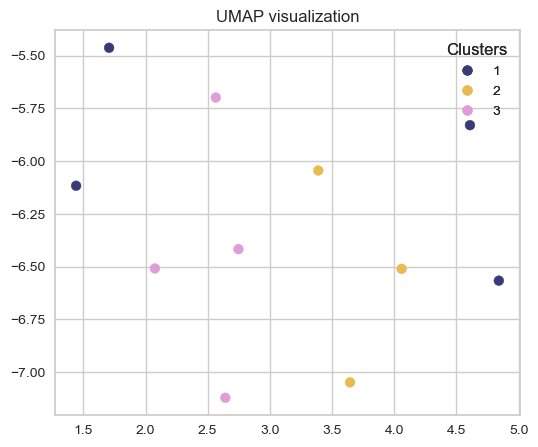

In [22]:
plot_umap_clusters(
    emb_sents,
    wiki_df["bow_kmeans"],
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_kmeans"],
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_dbscan"],
)

plot_umap_clusters(
    emb_sents,
    wiki_df["emb_hierarchical"],
)

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: [Food.com](https://www.food.com/) recipes 
<hr>

Now that we have applied document clustering on a toy corpus, let's move to a more realistic corpus. 

In the lecture, we worked on an activity of manually clustering food items and discussed challenges associated with it. We also applied different clustering algorithms to cluster food images. We'll continue this theme of clustering food items in this lab. But instead of images we will cluster textual description of food items, i.e., recipe names.   

In this lab, we will work with a sample of [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and **not** on reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find categories or groupings of recipes from this corpus based on their names. 

**Your tasks:**

- Download [`RAW_recipes.csv`](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions?select=RAW_recipes.csv) and put it under the `data` directory in the homework folder. 
- Run the code below. The dataset is quite large, and in this assignment, for speed, you will work with a sample of the dataset. The function `get_recipes_sample` below carries out some preliminary preprocessing and returns a sample of the recipes with most frequent tags. 

> *Note: Depending upon the capacity of your computer, feel free to increase or decrease the size of this sample by changing the value for `n_tags`. If you decide to go with a different value of `n_tags`, state it clearly in Exercise 2.1 so that the grader knows about it.* 

In [23]:
orig_recipes_df = pd.read_csv("data/RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [24]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    # Remove rows where recipe names are too short (< 5 characters).
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len]
    # Only consider the rows where tags are one of the most frequent n tags.
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist()
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [25]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [26]:
recipes_df["name"]

42        i yam what i yam  muffins    
101       to your health  muffins      
129       250 00 chocolate chip cookies
138       lplermagronen                
163       california roll   salad      
                   ...                 
231430    zucchini wheat germ cookies  
231514    zucchini blueberry bread     
231547    zucchini salsa burgers       
231596    zuppa toscana                
231629    zydeco salad                 
Name: name, Length: 9100, dtype: object

<br><br>

**In the rest of the homework, we will use `recipes_df` above, which is a subset of the original dataset.** 

<br><br>

<!-- BEGIN QUESTION -->

### 2.1 Longest and shorter recipe names 
rubric={points:2}

**Your tasks:**

1. Print the shortest and longest recipe names (length in terms of number of characters) from `recipes_df`. If there is more than one recipe with the same shortest/longest length, store **one** of them in `shortest_recipe` and/or `longest_recipe` as a **string**.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 2

In [27]:
recipes_df['name_length'] = recipes_df['name'].apply(len)
recipes_df


shortest_recipe = recipes_df.loc[recipes_df['name_length'].idxmin(), 'name']
longest_recipe = recipes_df.loc[recipes_df['name_length'].idxmax(), 'name']
print(shortest_recipe)
print(longest_recipe)

bread
baked tomatoes with a parmesan cheese crust and balsamic drizzle


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 More EDA
rubric={points:2}

**Your tasks:**
1. Create a word cloud for the recipe names. You can use [the `wordcloud` package](https://github.com/amueller/word_cloud) for this, which you will have to install in the course environment.
```
> conda activate cpsc330
> conda install -c conda-forge wordcloud
```

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 2

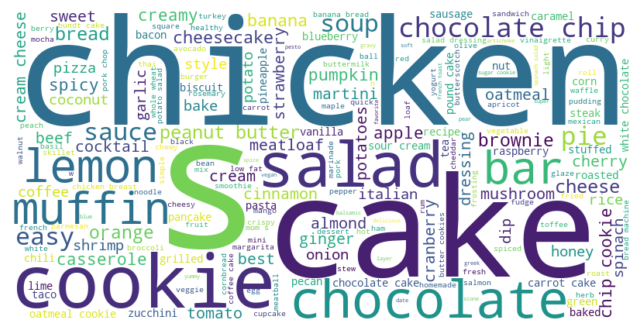

In [28]:
text = " ".join(recipes_df['name'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.3 Representing recipe names
rubric={points:3}

The next step is creating a representation of recipe names. 

**Your tasks:**

1. Similar to Exercise 1, create sentence embedding representation of recipe names (`name` column in `recipes_df`).  For the rest of the homework, we'll stick to the sentence embedding representation of recipe names.


> You might have to convert the recipe names to a list (`recipes_df["name"].tolist()`) for the embedder to work
> *If you create a dataframe with sentence embedding representation, set the index to `recipes_df.index` so that the indices match with the indices of the sample we are working with.*  
> **This might take a while to run.**


<div class="alert alert-warning">

Solution_2.3
    
</div>

_Points:_ 3

In [29]:
emb_recipes = embedder.encode(recipes_df["name"].tolist())
embeddings =  pd.DataFrame(emb_recipes, index = recipes_df.index)
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
42,-0.333474,0.227865,-0.307339,0.410549,0.917103,-0.345506,0.305810,0.256676,-0.147712,0.040727,...,-0.053025,-0.209463,0.362418,-0.246085,0.208379,-0.024874,0.506561,0.197738,-0.386421,-0.002184
101,-0.024523,0.246223,-0.055708,0.358273,0.454786,-0.088054,0.260368,0.231947,0.093013,-0.007835,...,0.144860,-0.435459,0.208343,-0.002655,-0.081200,-0.130489,0.452378,0.186310,-0.278500,0.028580
129,-0.026562,0.194671,0.038102,-0.099181,0.653784,-0.230868,0.064517,0.001376,-0.061280,0.232094,...,0.169605,0.239354,0.392649,0.271398,-0.093971,0.060101,-0.281418,0.133211,-0.122345,-0.109863
138,-0.168002,-0.219218,0.330761,0.302196,-0.173169,0.204557,0.192390,0.140975,0.303174,0.038063,...,0.019094,-0.002447,0.437833,0.563785,0.033442,0.187657,0.529252,-0.233786,0.509931,0.410715
163,0.061076,-0.333798,0.242906,0.395977,-0.466468,0.496505,-0.136754,0.122097,0.114248,0.065317,...,0.044438,-0.213657,0.410353,-0.233599,-0.224422,0.094330,0.173351,0.105781,-0.114749,-0.150677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231430,-0.009714,0.200162,0.018329,0.237816,0.748988,0.121919,0.087918,0.216755,-0.291041,0.074165,...,-0.120459,0.162877,0.480064,0.235902,0.146278,0.252980,-0.063639,-0.066044,-0.133067,-0.034040
231514,-0.106532,-0.034574,0.160070,0.258504,0.882480,0.091899,0.008815,0.372013,-0.266542,0.085018,...,0.063240,-0.099132,0.332694,0.031869,0.582796,0.216874,0.241107,0.091759,-0.261551,-0.082310
231547,0.016149,-0.053035,-0.035097,-0.021835,0.735161,0.245519,-0.151837,0.003954,0.102566,0.001363,...,0.102296,0.023821,0.602685,-0.067070,0.177535,0.253982,0.242439,-0.436000,-0.053910,0.012423
231596,0.026659,0.202483,0.344633,-0.138708,0.514424,0.630948,-0.003165,-0.102897,-0.434900,-0.192056,...,-0.162457,0.130696,0.113645,0.186650,-0.155392,0.130507,1.146239,-0.240862,0.236831,0.177122


<!-- END QUESTION -->

<br><br><br><br>

## Exercise 3: Clustering recipe names
<hr>

In this exercise you'll cluster recipe names with some of the clustering algorithms we have seen in class. This will also involve making some attempts to pick reasonable hyperparameter values for each clustering method based on the quality of the resulting clusters. For example, for KMeans, you need to specify the number of clusters in advance, which is often challenging on real-world datasets. For DBSCAN, you need to pick appropriate `eps` and `min_samples`. For hierarchical clustering, you need to pick a suitable linkage criterion, distance metric, and prune the tree so that it's possible to visualize and interpret it. 

Here are some methods which may help you with picking reasonable values for the hyperparameters. 
- Visualize the Elbow plot (KMeans). 
- Visualize Silhouette plots. 
- Visualize resulting clusters using `plot_umap_clusters` function from Exercise 1. 
- Sample some recipes from each cluster, manually inspect whether there are coherent semantic themes. (For this, you may use the function `print_clusters` given below.) 
        
> You may use the [`yellowbrick`](https://www.scikit-yb.org/en/latest/) package for visualizing the Elbow plot and the Silhouette plots. You can intall it with

```conda install -c districtdatalabs yellowbrick```

**Note that the process of picking reasonable hyperparameter values will be exploratory, iterative, and will involve manual inspection and judgment, as there is no ground truth to verify how well the model is doing. In your solutions, please do not include everything you try. Only present the results of the most informative trials. Add a narrative to your answer so that it's easy for the grader to follow your choices and reasoning.** 

In [30]:
def print_clusters(recipes_df, cluster_labels, n_recipes=10, replace=False, random_state=None):
    """
    Given recipes_df containing recipe names and cluster assignment (labels), 
    sample and print n_recipes recipes per cluster. 

    Parameters
    -----------
    recipe_df : pandas dataframe 
        recipes dataframe containing recipe names in the "name" column
    cluster_labels : ndarray or a list
        cluster labels for each row in recipes_df 
    n_recipes : int
        number of examples to sample from each cluster
    replace: bool
        replace flag to pass to the sampling of recipe names

    Returns
    -----------
    None
    """    
    
    grouped = (
        pd.DataFrame(
            {
                "name": recipes_df["name"],
                "cluster_label": cluster_labels,
            }
        )
        .sort_values("cluster_label")
        .groupby("cluster_label")    
    )
    
    for name, group in grouped:
        print(f"Cluster {name}")        
        print(("----------").format(""))        
        print("\n".join(group.sample(n_recipes, random_state=random_state)['name'].tolist()))
        print("\n\n")

<br><br>

<!-- BEGIN QUESTION -->

### 3.1 K-Means
rubric={points:6}

**Your tasks:**

1. Cluster recipe titles using KMeans. Make some attempts to determine the optimal number of clusters. 
2. Pick one or two best models and justify your choice. 

<div class="alert alert-warning">

Solution_3.1
    
</div>

_Points:_ 6

I used an elbow plot to determine the best k for kmeans clustering which was a k of 3, then I used print_clusters to check if my clusters made sense

In [31]:
kmeans = KMeans(random_state=42)
kmeans.fit(emb_recipes)

KMeans(random_state=42)

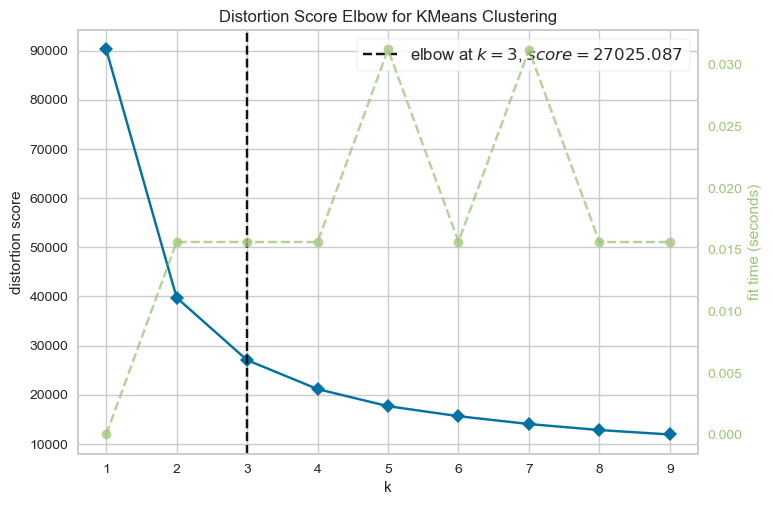

In [32]:
visualizer = KElbowVisualizer(kmeans, k=(1, 10))
X = visualizer.fit_transform(emb_recipes)
visualizer.fit(X) 
visualizer.show();

In [33]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(emb_recipes)
kmeans_recipes_labels = kmeans.labels_
recipes_df["emb_kmeans"] = kmeans_recipes_labels
recipes_df.shape

(9100, 14)

In [34]:
print_clusters(recipes_df, recipes_df["emb_kmeans"])

Cluster 0
----------
raspberry cider
rita s polenta lasagna
queso catfish
chambord royale
mad hatter
american flag
easiest peppermint iced tea
gorgonzola focaccia
pear and lime martini
apricot empanadas  easy



Cluster 1
----------
absolute best potatoes  5fix
sweet  n smoky oven bbq chicken
lamb souvlaki
garlic shrimp in yogurt
mozzarella meatballs
tropical glazed chicken strips
shrimp and snow peas in black beans sauce
crumb coated chicken thighs
fluffy rice and chicken
my own spicy sweet noodle kugel



Cluster 2
----------
low fat whole wheat banana nut chocolate chip cookies
drop sugar cookies
choc orange bread   butter pudding
raspberry chocolate chip bundt cake
cake with green tomatoes and cream cheese frosting
apple raisin loaves
chocolate melting moments
melt in your mouth tea cookies
blueberry  raspberry and blackberry cheesecake
chocolate peppermint bark cookies   bon appetit





<!-- END QUESTION -->

<br><br><br><br>

<!-- BEGIN QUESTION -->

### 3.2 DBSCAN
rubric={points:6}

**Your tasks:**

1. Cluster recipe names using `DBSCAN` with `metric="cosine"`. Make some attempts to tune the  hyperparameters `eps` and `min_samples`. 

<div class="alert alert-warning">

Solution_3.2
    
</div>

_Points:_ 6

Tuning hyperparameters for DBSCAN was diffcult since there was a fine line between having too many noise points and clustering being too general with every point falling into cluster 0 and clustering being too stringent with hundreds of clusters. In the end we settled on a eps of 0.4 and min_samples of 3. This made more clusters than I would like and the presence of a massive cluster 0 made the graph unhelpful. 

Cluster counts:
Cluster 0: 7660 points
Noise points (-1): 1356
Cluster 15: 5 points
Cluster 1: 3 points
Cluster 2: 3 points
Cluster 3: 3 points
Cluster 4: 5 points
Cluster 5: 5 points
Cluster 6: 3 points
Cluster 7: 3 points
Cluster 8: 5 points
Cluster 9: 3 points
Cluster 10: 3 points
Cluster 11: 4 points
Cluster 12: 3 points
Cluster 17: 3 points
Cluster 13: 3 points
Cluster 14: 3 points
Cluster 16: 3 points
Cluster 19: 3 points
Cluster 20: 3 points
Cluster 18: 3 points
Cluster 23: 3 points
Cluster 21: 3 points
Cluster 22: 3 points
Cluster 24: 3 points
Cluster 25: 3 points


C:\Users\User\AppData\Local\Temp\ipykernel_22780\943539974.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


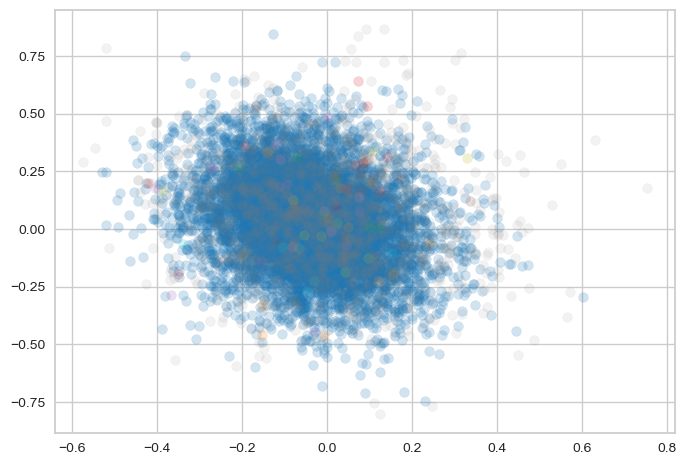

In [35]:
from collections import Counter
dbscan = DBSCAN(eps = 0.4, min_samples = 3, metric='cosine')
dbscan.fit(emb_recipes)
labels = dbscan.labels_

label_counts = Counter(labels)

# Print the counts of each cluster
print("Cluster counts:")
for label, count in label_counts.items():
    if label == -1:
        print(f"Noise points (-1): {count}")  
    else:
        print(f"Cluster {label}: {count} points")

unique_labels = set(labels)
colors = plt.cm.get_cmap("tab10", len(unique_labels))  

for i, label in enumerate(unique_labels):
    if label == -1:
        plt.scatter(emb_recipes[labels == label, 0], 
                    emb_recipes[labels == label, 1], 
                    color='gray', label=f"Noise ({np.sum(labels == -1)})", alpha=0.1)
    else:
        plt.scatter(emb_recipes[labels == label, 0], 
                    emb_recipes[labels == label, 1], 
                    color=colors(i), label=f"Cluster {label} ({np.sum(labels == label)})", alpha=0.2)
plt.show()

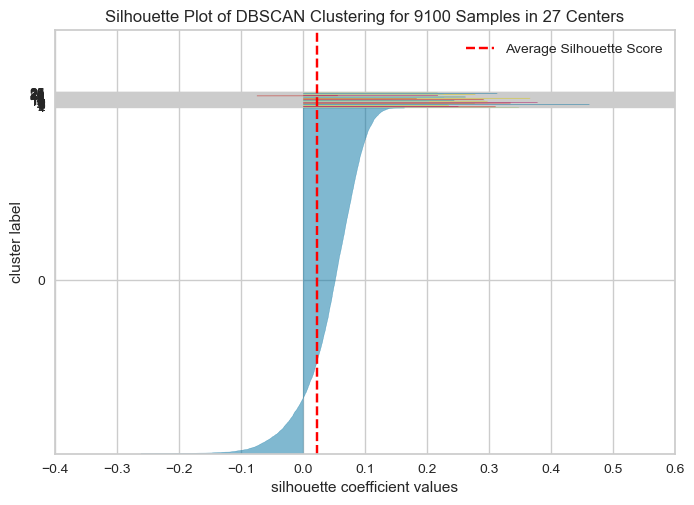

Cluster -1
----------
mamaliga
broiled sirloins



Cluster 0
----------
tunnel of fudge cake  cake mix
aloha quick bread



Cluster 1
----------
amarula coffee
amarula delight



Cluster 2
----------
american dream
american flag



Cluster 3
----------
lemon appletini
appletini



Cluster 4
----------
biscuit balls
biscuit sliders



Cluster 5
----------
blue lady
white lady  no egg



Cluster 6
----------
escargots bourguignonne
boeuf bourguignon



Cluster 7
----------
old fashioned
wisconsin brandy or whiskey old fashioned



Cluster 8
----------
pear sidecar
classic sidecar



Cluster 9
----------
kool aid cocktail
canadian killer kool aid recipe



Cluster 10
----------
champagne mojitos
gino s marvelous mojitos



Cluster 11
----------
mughlai chicken   nigella lawson
cheese pancakes    nigella lawson



Cluster 12
----------
chicken kiev with a kick
light chicken kiev



Cluster 13
----------
citrus cod
citrus trifle



Cluster 14
----------
creamy citrus cooler
orange brandy co

In [36]:
n_clusters = len(set(dbscan.labels_))
dbscan.n_clusters = n_clusters
dbscan.predict = lambda x: dbscan.labels_
visualizer = SilhouetteVisualizer(dbscan, colors="yellowbrick")
visualizer.fit(emb_recipes)
visualizer.show();
recipes_df["emb_dbscan"] = labels
print_clusters(recipes_df, recipes_df["emb_dbscan"], n_recipes = 2)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.3 Hierarchical clustering
rubric={points:6}

**Your tasks:**

1. Try hierarchical clustering with `metric="cosine"` on this problem. Show a dendrogram by using a suitable truncation method. 
2. Create flat clusters by cutting the tree at the appropriate level. 

> *Note: Try orientation="left" of `dendrogram` for better readability of the dendrogram.*

<div class="alert alert-warning">

Solution_3.3
    
</div>

_Points:_ 6

i chose to use complete linkage to ensure that when i merge groups together im choosing the one that are the most similar among its most different points to ensure groups don't have unrelated outliers that can confuse what each group represents. After exploring potential numbers of clusters 3 gave clear and easily identifiable categories such as drinks, entrees, and desserts though there are some incorrect clustering such as a baklava which is a dessert being with the entrees. 

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [20.0, 20.0, 42.5, 42.5],
  [5.0, 5.0, 31.25, 31.25],
  [75.0, 75.0, 85.0, 85.0],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [95.0, 95.0, 112.5, 112.5],
  [80.0, 80.0, 103.75, 103.75],
  [65.0, 65.0, 91.875, 91.875],
  [18.125, 18.125, 78.4375, 78.4375],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [142.5, 142.5, 173.75, 173.75],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [265.0, 265.0, 275.0, 275.0],
  [242.5, 242.5, 270.0, 270.0],
  [212.5, 212.5, 256.25, 256.25],
  [158.125, 158.125, 234.375, 234.375],
  [48.28125, 48.28125, 196.25, 196.25],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [335.0, 335.0, 345.0, 345.0]

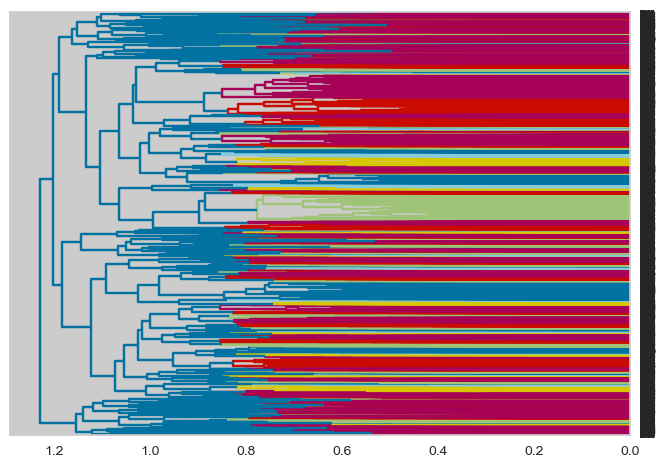

In [37]:
linkage_array = linkage(emb_recipes, method = "complete", metric = "cosine") 
dendrogram(linkage_array, orientation="left")

In [38]:
hier_emb_labels = fcluster(linkage_array, 3, criterion = "maxclust") 
recipes_df["emb_hierarchical"] = hier_emb_labels
recipes_df

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,name_length,emb_kmeans,emb_dbscan,emb_hierarchical
42,i yam what i yam muffins,93958,45,133174,2004-06-22,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[171.8, 9.0, 28.0, 10.0, 8.0, 4.0, 8.0]",10,"['preheat oven to 375 degrees', 'spray muffin tin with non-stick cooking spray and set aside', 'place the raisins in a small bowl and pour the 1 / 4 cup boiling water over them', 'cover and set aside while preparing batter', 'combine the flours , cocoa , baking powder , cinnamon , cloves , baking soda , and salt', 'lightly beat eggs with sorghum , oil , mashed yams and orange juice', 'add the egg mixture and buttermilk alternately to the dry ingredients , stir until well blended', 'drain the raisins and add to batter along with orange peel', 'spoon batter into prepared muffin tins , sprinkle 1 / 4 to 1 / 2 tsp of granulated sugar over each muffin', 'bake in preheated oven for 15 to 20 minutes']","these muffins may have slightly different ingredients but the end result is a wonderful rich, moist muffin. the sugar sprinkled on top before cooking gives a slightly sweet crunch and cracked glazed appearance.","['all-purpose flour', 'buckwheat flour', 'unsweetened cocoa', 'baking powder', 'baking soda', 'salt', 'ground cinnamon', 'ground cloves', 'sorghum', 'eggs', 'yam', 'low-fat buttermilk', 'orange rind', 'orange juice', 'canola oil', 'raisins', 'boiling water', 'granulated sugar']",18,25,2,0,3
101,to your health muffins,61973,40,33823,2003-05-12,"['60-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'muffins', 'quick-breads']","[159.0, 8.0, 58.0, 10.0, 7.0, 4.0, 8.0]",5,"['blend together in large bowl flour , bran , brown sugar , baking soda , salt , cinnamon , carrots and raisins', 'in second bowl , beat buttermilk , oil , egg and vanilla', 'add liquid ingredients to dry ingredients and mix just until moistened', 'spoon into 12 greased or paper-lined muffin cups', 'bake at 375f for 20 minutes']","these muffins sound like they are very healthy for you, and pretty easy to make. another one of my great finds. to your health. enjoy","['whole wheat flour', 'natural bran', 'brown sugar', 'baking soda', 'salt', 'cinnamon', 'carrot', 'raisins', 'buttermilk', 'corn oil', 'egg', 'vanilla']",12,23,2,0,3
129,250 00 chocolate chip cookies,118843,20,145599,2005-04-24,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'drop-cookies', 'desserts', 'easy', 'cookies-and-brownies', '3-steps-or-less']","[5286.9, 427.0, 1630.0, 159.0, 163.0, 656.0, 224.0]",3,"['mix all ingredients together just until blended', 'spoon large tbspfuls onto a baking sheet', 'bake at 350 for 10-14 minutes']",these are great! the perfect name for them!,"['butter', 'white sugar', 'brown sugar', 'eggs', 'vanilla', 'flour', 'oatmeal', 'salt', 'baking powder', 'baking soda', 'chocolate chips', ""hershey's semi-sweet baking chocolate"", 'nuts']",13,29,2,0,3
138,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'preparation']","[651.8, 33.0, 12.0, 16.0, 32.0, 63.0, 33.0]",15,"['heat oven to 375f set a large pot of salted water to boil', 'heat butter / oil over medium-low heat in a frying pan', 'add onions and fry them until golden brown', 'add penne and potatoes to the salted water', 'stir to make sure pasta doesnt stick together', 'cook until tender , about 15 minutes', 'drain penne and potatoes', 'combine milk / cream with salt and pepper', 'in an ovenproof casserole dish , place 1 / 3 of the penne-potatoes , sprinkle with 1 / 2 of the grated cheese', 'make another layer with 1 / 3 of the penne-potatoes , sprinkle with the other 1 / 2 of the grated cheese', 'top with the remaining 1 / 3 of the penne-potatoes', 'pour the seasoned milk / cream evenly over the top', 'spread the browned onions on top', 'bake covered for 10-15 minutes until steaming hot and 

In [39]:
print_clusters(recipes_df, recipes_df["emb_hierarchical"], n_recipes = 5)

Cluster 1
----------
cranberry dream bars
shark attack  cocktail
black and blue cranberry smoothie
glacial mists cooler
whiskey lemonade



Cluster 2
----------
st  louis salad
better than fried chimichangas
roasted rabbit with garlic and olives
crazy crust sausage pizza
pan seared sea scallops on red onion marmalade



Cluster 3
----------
banana bread   quick bread for machines
apple and honey filled crepes
sex on the grass
lemon snowdrift bars
skip and go barefoot





<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 3.4 Manual interpretation of clusters
rubric={points:6}

**Your tasks:**

1. Label the topics/themes you see in the clusters created by different clustering methods.  
2. Do you see a common theme across clusters created by different clustering methods? Do you see any differences between the clusters created by different clustering methods? 

<div class="alert alert-warning">

Solution_3.4
    
</div>

_Points:_ 6

kmeans and hierarchical clustering both had the themes of drinks, entrees, and desserts among its clusters but dbscan had trouble finding themes and had many noise points and and overly large cluster 0 that hurt the other clusters it made. 

<!-- END QUESTION -->

<br><br><br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)